In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


purchaser_sessions = pd.read_csv('data/purchaser_sessions.csv')
purchaser_sessions['session_date'] = pd.to_datetime(purchaser_sessions['session_date'])


In [3]:
purchaser_sessions.columns

Index(['session_key', 'user_pseudo_id', 'session_id', 'session_date',
       'session_start_ts', 'session_end_ts', 'session_duration_seconds',
       'session_duration_minutes', 'session_number', 'is_purchaser',
       'has_purchase_event', 'has_transaction_id', 'user_session_type',
       'is_first_session', 'is_bounce', 'has_engagement', 'is_engaged_30s',
       'is_engaged_1min', 'is_engaged_3min', 'operating_system',
       'operating_system_version', 'browser', 'browser_version',
       'device_category', 'platform', 'mobile_brand_name', 'mobile_model_name',
       'mobile_marketing_name', 'mobile_os_hardware_model', 'device_language',
       'is_limited_ad_tracking', 'time_zone_offset_seconds', 'country',
       'region', 'city', 'traffic_source', 'traffic_medium',
       'traffic_campaign', 'landing_page', 'exit_page', 'referrer',
       'product_views', 'add_to_carts', 'checkouts_started', 'purchases',
       'reached_product_view', 'reached_add_to_cart', 'reached_checkout',
  

## Geolocation Analysis

In [9]:
purchaser_sessions.groupby('country').agg({'session_id': 'nunique', 'user_pseudo_id': 'nunique', 'revenue_clean': 'sum'}).reset_index().sort_values(by='session_id', ascending=False)

,country,session_id,user_pseudo_id,revenue_clean
105,United States,155985,118493,112911.62
43,India,33670,25367,22083.38
18,Canada,26751,20268,24480.43
104,United Kingdom,11313,8527,8133.24
33,France,7159,5381,4334.32
...,...,...,...,...
77,Paraguay,72,51,30.05
99,Trinidad & Tobago,71,55,0.00
54,Kosovo,71,53,20.08
62,Malta,70,57,0.00


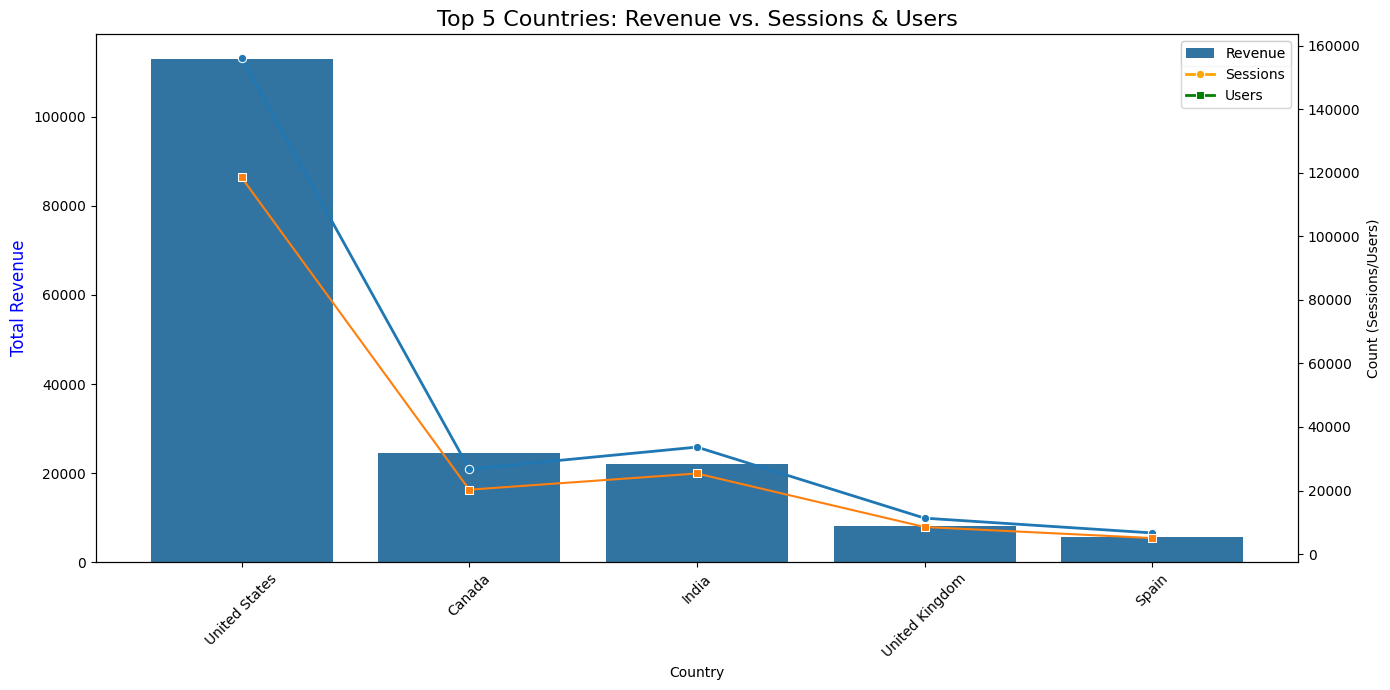

In [22]:

country_viz_df = purchaser_sessions.groupby('country').agg(
    total_revenue=('revenue_clean', 'sum'),
    session_count=('session_id', 'nunique'),
    user_count=('user_pseudo_id', 'nunique')
).sort_values('total_revenue', ascending=False).head(5) 

fig, ax1 = plt.subplots(figsize=(14, 7))

sns.barplot(x=country_viz_df.index, y='total_revenue', data=country_viz_df, ax=ax1, label='Revenue')
ax1.set_ylabel('Total Revenue', color='blue', fontsize=12)
ax1.tick_params(axis='y')
ax1.set_xlabel('Country')
plt.xticks(rotation=45)

ax2 = ax1.twinx()
sns.lineplot(x=country_viz_df.index, y='session_count', data=country_viz_df, ax=ax2, marker='o', label='Sessions', linewidth=2)
sns.lineplot(x=country_viz_df.index, y='user_count', data=country_viz_df, ax=ax2, marker='s', label='Users')
ax2.set_ylabel('Count (Sessions/Users)')
ax2.tick_params(axis='y')

plt.title('Top 5 Countries: Revenue vs. Sessions & Users', fontsize=16)
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

## Engagement RFM Analysis

In [358]:
SESSION_PK = "session_key" if "session_key" in purchaser_sessions.columns else "session_id"

# Strict definition if available (recommended)
if "has_transaction_id" in purchaser_sessions.columns:
    purchaser_sessions["is_valid_purchase_session"] = (
        purchaser_sessions["has_transaction_id"] & (purchaser_sessions["revenue_clean"] > 0)
    )
else:
    purchaser_sessions["is_valid_purchase_session"] = (
        purchaser_sessions["is_purchaser"] & (purchaser_sessions["revenue_clean"] > 0)
    )

duration_all = (
    purchaser_sessions
    .groupby("engagement_cohort", dropna=False)
    .agg(
        Sessions=(SESSION_PK, "nunique"),
        Revenue_Total=("revenue_clean", "sum"),
        Valid_Purchase_Sessions=("is_valid_purchase_session", "sum"),
        Avg_Duration_Min=("session_duration_minutes", "mean"),
    )
)

duration_all["Purchase_Rate"] = duration_all["Valid_Purchase_Sessions"] / duration_all["Sessions"]
duration_all["RPS"] = duration_all["Revenue_Total"] / duration_all["Sessions"]

duration_all


,Sessions,Revenue_Total,Valid_Purchase_Sessions,Avg_Duration_Min,Purchase_Rate,RPS
engagement_cohort,,,,,,
0s (Bounce),58673,0.00,0,0.000000,0.000000,0.000000
1-10s,110266,0.00,0,0.081284,0.000000,0.000000
1-3min,40623,2333.03,37,1.798816,0.000911,0.057431
11-30s,50489,38.40,1,0.312243,0.000020,0.000761
3-5min,16330,5084.99,97,3.911175,0.005940,0.311389
31-60s,28229,0.00,0,0.724275,0.000000,0.000000
5min+,56151,242934.24,2505,17.974119,0.044612,4.326445


In [359]:
actual_purchasers = purchaser_sessions[
    (purchaser_sessions['is_purchaser'] == True) & 
    (purchaser_sessions['revenue_clean'] > 0)
].copy()
# Determine session key column
SESSION_PK = "session_key" if "session_key" in actual_purchasers.columns else "session_id"

In [360]:
# Ensure product_views is numeric
actual_purchasers["product_views"] = pd.to_numeric(actual_purchasers["product_views"], errors="coerce").fillna(0)
# Create bins for product views
actual_purchasers["product_view_bins"] = pd.cut(
    actual_purchasers["product_views"],
    bins=[0, 5, 10, 20, 50, float('inf')],
    labels=["0-5", "6-10", "11-20", "21-50", "50+"],
    right=True
)
# Analyze by product view bins
product_view_analysis = actual_purchasers.groupby("product_view_bins").agg(
    session_count=(SESSION_PK, 'nunique'),
    total_revenue=('revenue_clean', 'sum'),
    avg_revenue=('revenue_clean', 'mean'),
    avg_session_duration=('session_duration_minutes', 'mean'),
    avg_add_to_carts=('add_to_carts', 'mean'),
    avg_checkouts=('checkouts_started', 'mean')
)
print(product_view_analysis)

                   session_count  total_revenue  avg_revenue  \
product_view_bins                                              
0-5                          777       40371.89    51.958674   
6-10                         582       44601.48    76.634845   
11-20                        737       66498.22    90.228250   
21-50                        616       72095.24   117.037727   
50+                          124       21189.26   170.881129   

                   avg_session_duration  avg_add_to_carts  avg_checkouts  
product_view_bins                                                         
0-5                           13.741081          1.198198       3.734878  
6-10                          19.569519          2.881443       4.161512  
11-20                         25.770488          5.256445       4.348711  
21-50                         39.516851          8.952922       5.566558  
50+                           63.844435         14.588710       7.153226  


/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykernel_3671/2073074238.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_view_analysis = actual_purchasers.groupby("product_view_bins").agg(


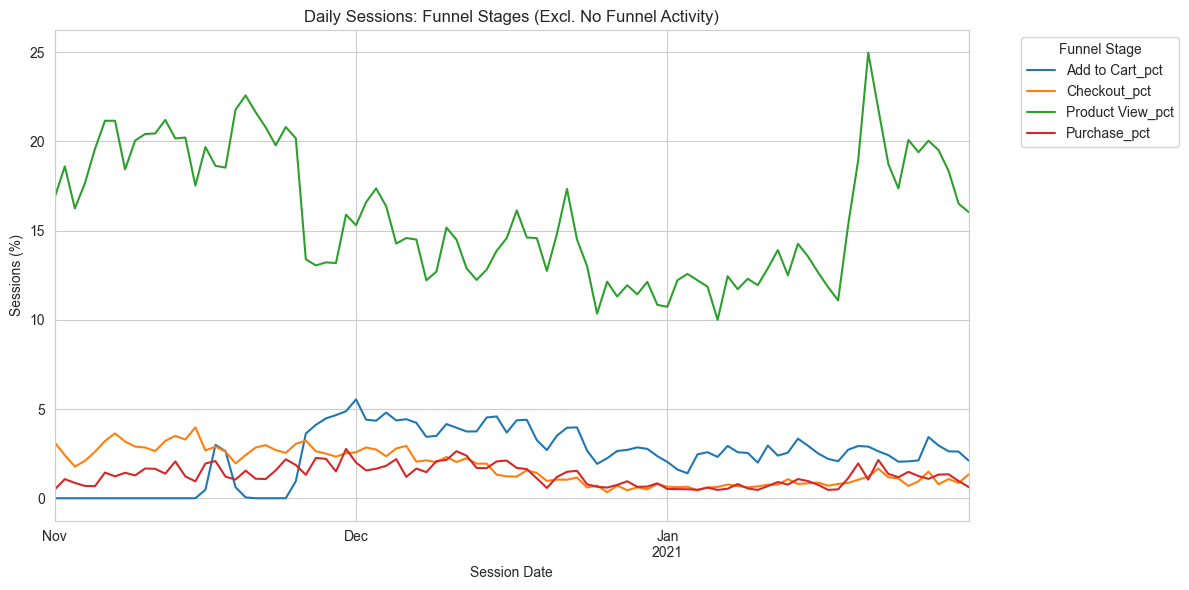

In [361]:
# Remove "No Funnel Activity"
pct_cols = [c for c in sessions_with_pct.columns if c.endswith('_pct')]

filtered_df_pct = sessions_with_pct[pct_cols].drop(columns=['No Funnel Activity_pct'], errors='ignore')

fig, ax2 = plt.subplots(figsize=(12, 6))
filtered_df_pct.plot(ax=ax2)

ax2.set_title('Daily Sessions: Funnel Stages (Excl. No Funnel Activity)')
ax2.set_ylabel('Sessions (%)')
ax2.set_xlabel('Session Date')
ax2.legend(title='Funnel Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Device analysis

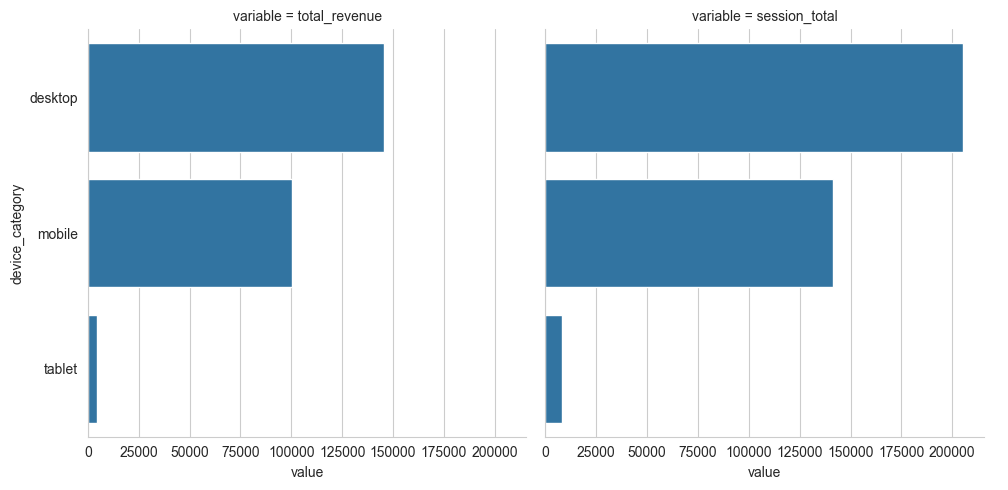

In [362]:
# Create a flag for invalid purchases (only for purchasers)
purchaser_sessions['is_invalid_purchase'] = (
    (purchaser_sessions['is_purchaser'] == True) & 
    (purchaser_sessions['revenue_clean'] == 0)
)

device_df = purchaser_sessions.groupby('device_category', as_index=False).agg(
    session_total=('session_id', 'nunique'),
    total_revenue=('revenue_clean', 'sum'),
    invalid_purchase_total=('is_invalid_purchase', 'sum')
)

sns.catplot(
    data=device_df.melt(id_vars="device_category", value_vars=["total_revenue", "session_total"]),
    kind="bar",
    y="device_category",
    x="value",
    col="variable",
    sharey=True
)


In [363]:
# Desktop

desktop_purchase_sessions = purchaser_sessions[purchaser_sessions['device_category'] == 'desktop']
desktop_purchase_sessions.groupby(['operating_system','browser']).agg(
    session_id=('session_id', 'nunique'),
    total_revenue=('revenue_clean', 'sum'),
    invalid_purchase_total=('is_invalid_purchase', 'sum'),
    session_duration = ('session_duration_minutes', 'mean')
)

session_id  total_revenue  invalid_purchase_total  \
operating_system browser                                                      
<Other>          <Other>          49           0.00                       0   
                 Chrome         8781        9285.05                      41   
                 Edge              3           0.00                       0   
                 Firefox         207         631.84                       3   
                 Safari            9           0.00                       0   
Macintosh        <Other>          52           0.00                       0   
                 Chrome        19574       15114.57                     112   
                 Edge             35           0.00                       0   
                 Firefox         445         365.64                       3   
                 Safari         6648        3493.07                      43   
Web              <Other>        1487         801.20                       5   
                 Chrome       109892       79869.95                     578   
                 Edge           5290        3170.41                      21   
                 Firefox        3922        1359.62                      15   
                 Safari         9927        4490.56                      50   
Windows          <Other>         822         459.84                       5   
                 Chrome        36037       25521.00                     203   
                 Edge           2701         696.52                       9   
                 Firefox        1801         463.92                      11   
                 Safari            2           0.00                       0   

                          session_duration  
operating_system browser                    
<Other>          <Other>          3.787551  
                 Chrome           3.545823  
                 Edge             1.123333  
                 Firefox          3.237053  
                 Safari           3.001111  
Macintosh        <Other>          2.446154  
                 Chrome           3.247132  
                 Edge             2.708000  
                 Firefox          3.512063  
                 Safari           3.342677  
Web              <Other>          3.357000  
                 Chrome           3.304218  
                 Edge             3.268579  
                 Firefox          3.029802  
                 Safari           3.294111  
Windows          <Other>          3.636444  
                 Chrome           3.325412  
                 Edge             3.082821  
                 Firefox          2.989751  
                 Safari          11.855000

/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykernel_3671/2087057328.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


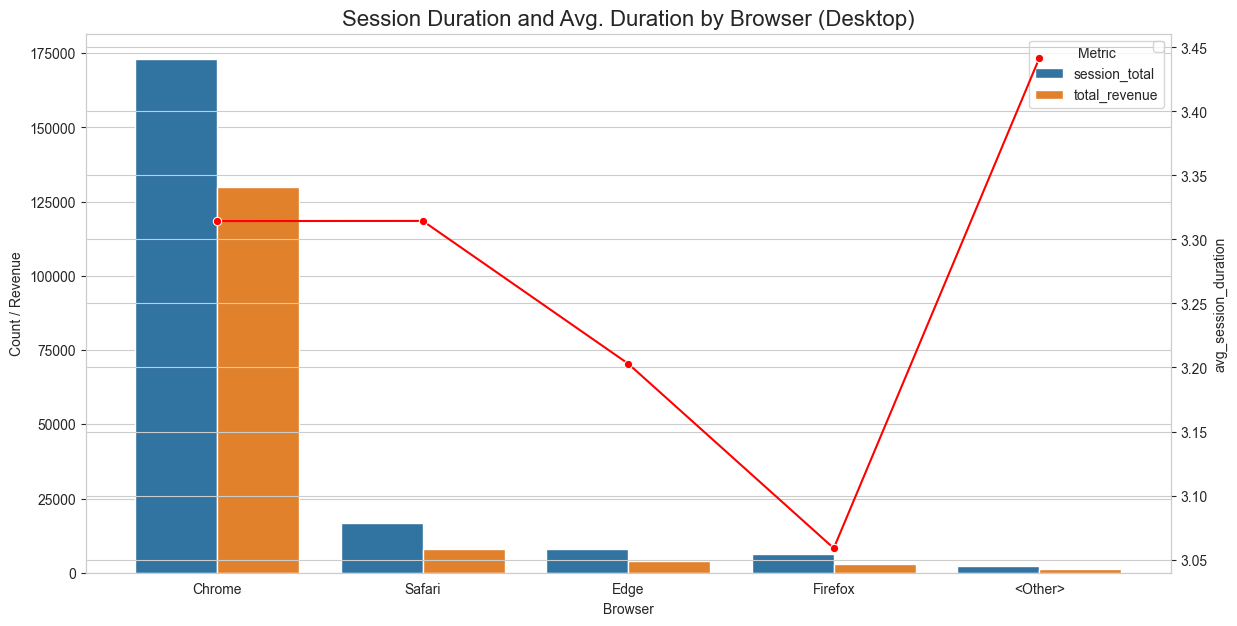

In [364]:
desktop_browser_df = desktop_purchase_sessions.groupby('browser').agg(
    session_total=('session_id', 'nunique'),
    total_revenue=('revenue_clean', 'sum'),
    avg_session_duration=('session_duration_minutes', 'mean')
)

plot_data = desktop_browser_df.sort_values('total_revenue', ascending=False).reset_index()
plot_data_melted = plot_data.melt(id_vars='browser', value_vars=['session_total', 'total_revenue'], var_name='Metric', value_name='Value')

fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for Session Total and Total Revenue
sns.barplot(data=plot_data_melted, x='browser', y='Value', hue='Metric', ax=ax1)
ax1.set_ylabel('Count / Revenue')
ax1.set_xlabel('Browser')
ax1.set_title('Session Duration and Avg. Duration by Browser (Desktop)', fontsize=16)

# Line plot for Session Duration on a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=plot_data, x='browser', y='avg_session_duration', ax=ax2, color='red', marker='o')
ax2.legend()

plt.show()

In [365]:
# Mobile

mobile_purchase_sessions = purchaser_sessions[purchaser_sessions['device_category'] == 'mobile']
mobile_purchase_sessions.groupby(['operating_system','browser']).agg(
    session_id=('session_id', 'nunique'),
    total_revenue=('revenue_clean', 'sum'),
    invalid_purchase_total=('is_invalid_purchase', 'sum'),
    session_duration = ('session_duration_minutes', 'mean')
)

session_id  total_revenue  \
operating_system browser                                      
<Other>          <Other>                  24           0.00   
                 Chrome                    9           0.00   
                 Safari                    3           0.00   
Android          <Other>                2375        1629.42   
                 Android Webview         970         441.12   
                 Chrome                26408       16078.96   
                 Firefox                 148         291.60   
Web              <Other>                3668        1617.84   
                 Android Webview        3448        2901.22   
                 Chrome                35789       26545.69   
                 Edge                      5           0.00   
                 Firefox                 235          98.60   
                 Safari                30637       23253.82   
Windows          Edge                      2           0.00   
iOS              <Other>                 219           0.00   
                 Chrome                 3312        1675.70   
                 Safari                35523       25582.16   

                                  invalid_purchase_total  session_duration  
operating_system browser                                                    
<Other>          <Other>                               0          0.937083  
                 Chrome                                0          4.931111  
                 Safari                                0         41.390000  
Android          <Other>                              19          3.567557  
                 Android Webview                       7          3.049969  
                 Chrome                              137          3.276798  
                 Firefox                               1          4.319459  
Web              <Other>                              24          3.417167  
                 Android Webview                      23          3.475973  
                 Chrome                              186          3.325458  
                 Edge                                  0          0.154000  
                 Firefox                               2          2.430000  
                 Safari                              176          3.329860  
Windows          Edge                                  0          0.425000  
iOS              <Other>                               0          2.548311  
                 Chrome                               21          3.317729  
                 Safari                              200          3.289192

/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykernel_3671/1525043861.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


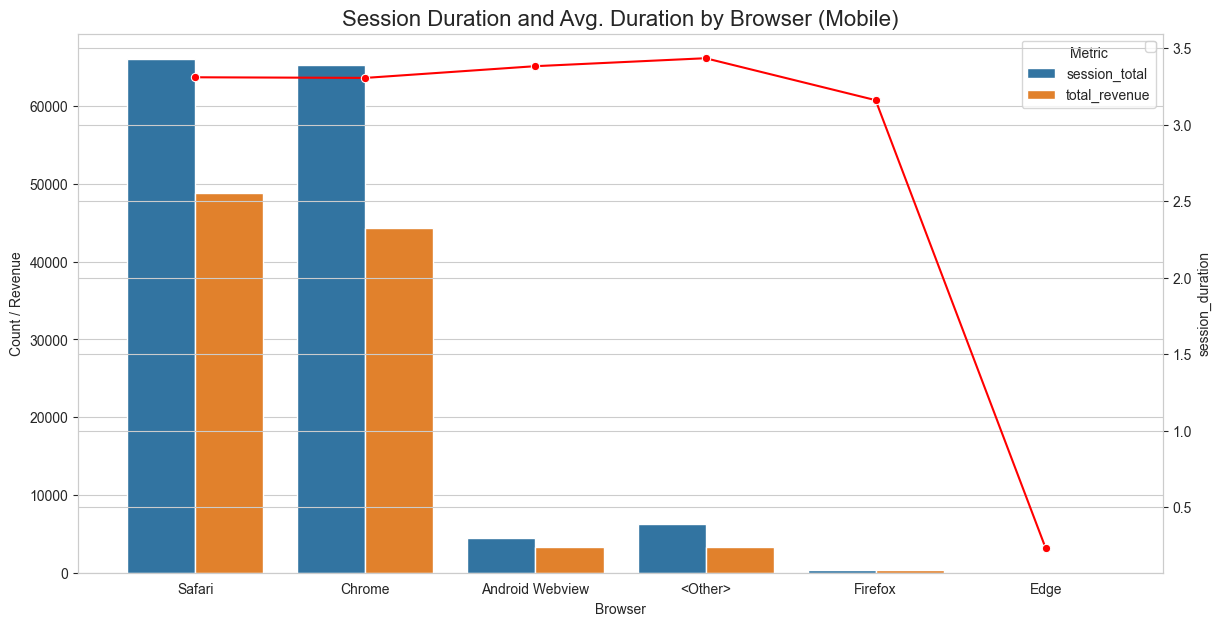

In [366]:
mobile_browser_df = mobile_purchase_sessions.groupby('browser').agg(
    session_total=('session_id', 'nunique'),
    total_revenue=('revenue_clean', 'sum'),
    session_duration = ('session_duration_minutes', 'mean')
)

plot_data = mobile_browser_df.sort_values('total_revenue', ascending=False).reset_index()
plot_data_melted = plot_data.melt(id_vars='browser', value_vars=['session_total', 'total_revenue'], var_name='Metric', value_name='Value')

fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for Session Total and Total Revenue
sns.barplot(data=plot_data_melted, x='browser', y='Value', hue='Metric', ax=ax1)
ax1.set_ylabel('Count / Revenue')
ax1.set_xlabel('Browser')
ax1.set_title('Session Duration and Avg. Duration by Browser (Mobile)', fontsize=16)

# Line plot for Session Duration on a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=plot_data, x='browser', y='session_duration', ax=ax2, color='red', marker='o')
ax2.legend()

plt.show()

# Funnel analysis

/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykernel_3671/3631331603.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=funnel_counts.index, y=funnel_counts.values, palette="viridis")


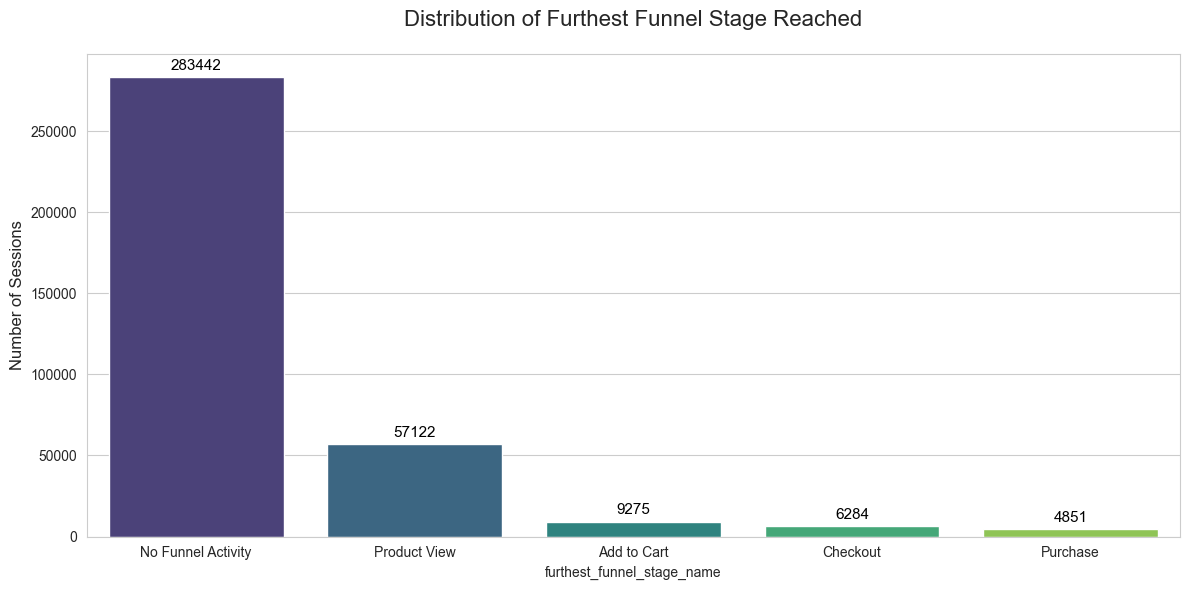

In [367]:
# Funnel
funnel_counts = purchaser_sessions['furthest_funnel_stage_name'].value_counts()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=funnel_counts.index, y=funnel_counts.values, palette="viridis")

plt.title('Distribution of Furthest Funnel Stage Reached', fontsize=16, pad=20)
plt.ylabel('Number of Sessions', fontsize=12)

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [368]:
purchaser_sessions.head()

,session_key,user_pseudo_id,session_id,session_date,session_start_ts,session_end_ts,session_duration_seconds,session_duration_minutes,session_number,is_purchaser,...,drop_off_stage,session_revenue,currency,revenue_clean,transaction_ids_list,first_transaction_id,transaction_count,engagement_cohort,is_valid_purchase_session,is_invalid_purchase
0,89198331.6844453937-5748775146,8.919833e+07,5748775146,2020-11-23,2020-11-23 13:17:56.330638 UTC,2020-11-23 13:18:01.909669 UTC,5,0.08,1,False,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1-10s,False,False
1,5062938.7581451134-9355207500,5.062939e+06,9355207500,2020-12-14,2020-12-14 20:34:57.070651 UTC,2020-12-14 20:35:01.731161 UTC,4,0.07,1,False,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1-10s,False,False
2,67362915.9991733559-9700278426,6.736292e+07,9700278426,2020-12-09,2020-12-09 02:10:25.39931 UTC,2020-12-09 02:10:32.750237 UTC,7,0.12,1,False,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1-10s,False,False
3,2988912.5107414146-2342593295,2.988913e+06,2342593295,2020-11-29,2020-11-29 00:58:13.568586 UTC,2020-11-29 01:26:55.98946 UTC,1722,28.70,1,False,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,5min+,False,False
4,43975819.3406717222-9341761021,4.397582e+07,9341761021,2020-11-01,2020-11-01 07:24:24.048355 UTC,2020-11-01 07:24:24.048355 UTC,0,0.00,2,False,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0s (Bounce),False,False


In [369]:
sessions_by_furthest_daily = (
    purchaser_sessions.groupby(['session_date', 'furthest_funnel_stage_name'])['session_key']
      .nunique()
      .unstack(fill_value=0)
)

sessions_by_furthest_daily['daily_total'] = purchaser_sessions.groupby('session_date')['session_key'].nunique()

In [370]:
stage_cols = sessions_by_furthest_daily.columns.drop('daily_total', errors='ignore')

pct = (sessions_by_furthest_daily[stage_cols]
       .div(sessions_by_furthest_daily['daily_total'], axis=0)
       .mul(100)
       .add_suffix('_pct'))

sessions_with_pct = sessions_by_furthest_daily.join(pct)


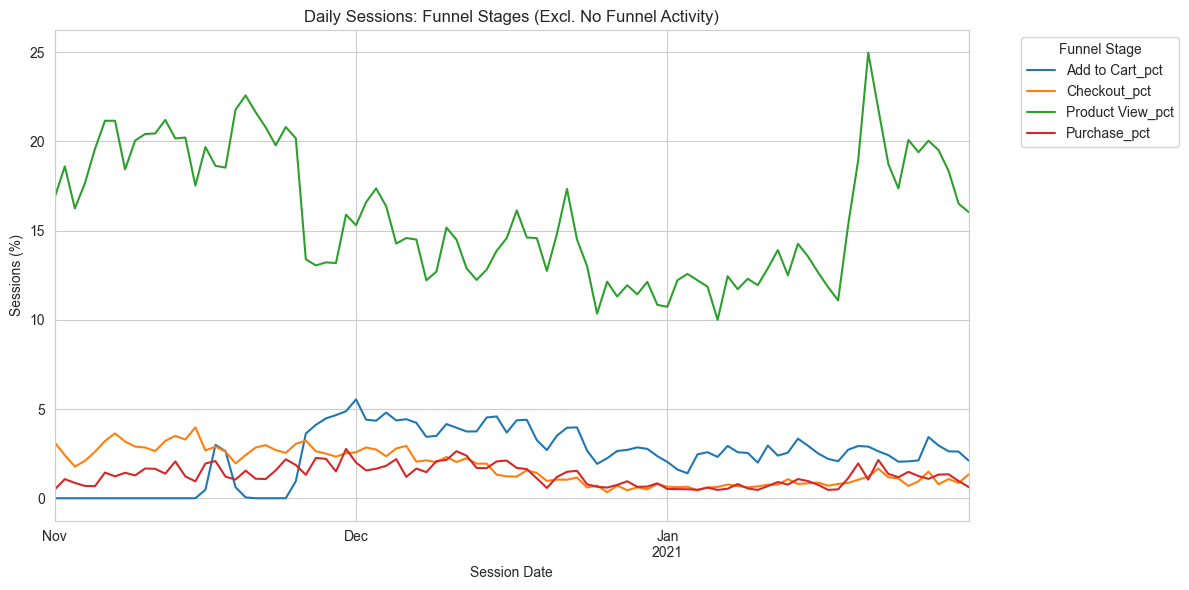

In [371]:
# Remove "No Funnel Activity"
pct_cols = [c for c in sessions_with_pct.columns if c.endswith('_pct')]

filtered_df_pct = sessions_with_pct[pct_cols].drop(columns=['No Funnel Activity_pct'], errors='ignore')

fig, ax2 = plt.subplots(figsize=(12, 6))
filtered_df_pct.plot(ax=ax2)

ax2.set_title('Daily Sessions: Funnel Stages (Excl. No Funnel Activity)')
ax2.set_ylabel('Sessions (%)')
ax2.set_xlabel('Session Date')
ax2.legend(title='Funnel Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [372]:
import pandas as pd
from urllib.parse import urlparse, unquote

landing_page_df = purchaser_sessions['landing_page'].value_counts()

s = landing_page_df
  # your Series: index=url, values=count

def canon(url: str) -> str:
    u = urlparse(url)
    path = unquote(u.path).lower()
    # drop trailing slash except root
    if path != "/" and path.endswith("/"):
        path = path[:-1]
    return path  # keep just path; host/protocol removed

lp = s.rename_axis("url").reset_index(name="count")
lp["path"] = lp["url"].map(canon)

lp_canon = lp.groupby("path", as_index=False)["count"].sum().sort_values("count", ascending=False)
lp_canon.head(10)


,path,count
0,/,161890
251,/google+redesign/apparel,40216
805,/google+redesign/shop+by+brand/youtube,25320
309,/google+redesign/apparel/google+dino+game+tee,18803
941,/store.html,15006
462,/google+redesign/apparel/mens/mens+t+shirts,7244
692,/google+redesign/lifestyle/drinkware,5762
458,/google+redesign/apparel/mens,5535
914,/signin.html,4329
42,/basket.html,4204


In [373]:
def page_type(path: str) -> str:
    if path in ["/", "/store.html"]:
        return "Home"
    if path.endswith("signin.html"):
        return "Auth"
    if path.endswith("basket.html"):
        return "Cart"
    if path.endswith("asearch.html"):
        return "Search"
    if path.startswith("/store-policies/"):
        return "Policies/Help"
    # heuristic: lots of segments often means PDP; adjust for your site
    segs = [p for p in path.split("/") if p]
    if len(segs) >= 4:
        return "Product (PDP)"
    if len(segs) in [1,2,3]:
        return "Category (PLP)"
    return "Other"

lp_canon["page_type"] = lp_canon["path"].map(page_type)

type_share = (lp_canon.groupby("page_type")["count"].sum()
              .sort_values(ascending=False)
              .to_frame("sessions"))
type_share["pct"] = type_share["sessions"] / type_share["sessions"].sum() * 100
type_share


,sessions,pct
page_type,,
Home,176896,49.005192
Category (PLP),160576,44.484090
Product (PDP),9299,2.576086
Auth,4331,1.199809
Cart,4204,1.164627
Policies/Help,3937,1.090660
Search,1729,0.478982
Other,2,0.000554


In [374]:
lp_canon2 = lp_canon.sort_values("count", ascending=False).reset_index(drop=True)
lp_canon2["cum_pct"] = lp_canon2["count"].cumsum() / lp_canon2["count"].sum() * 100
lp_canon2.head(10)[["path","count","cum_pct"]]


,path,count,cum_pct
0,/,161890,44.848105
1,/google+redesign/apparel,40216,55.989074
2,/google+redesign/shop+by+brand/youtube,25320,63.003430
3,/google+redesign/apparel/google+dino+game+tee,18803,68.212392
4,/store.html,15006,72.369478
5,/google+redesign/apparel/mens/mens+t+shirts,7244,74.376271
6,/google+redesign/lifestyle/drinkware,5762,75.972508
7,/google+redesign/apparel/mens,5535,77.505859
8,/signin.html,4329,78.705114
9,/basket.html,4204,79.869741


## Purchaser Analysis

In [375]:
purchaser_sessions.groupby('is_purchaser').agg(
    first_session=('is_first_session', 'mean'),
    session_duration_avg=('session_duration_minutes', 'mean')
)

,first_session,session_duration_avg
is_purchaser,,
False,0.729973,3.032258
True,0.367141,23.504209


In [376]:
purchaser_sessions.groupby(['is_purchaser', 'device_category']).agg(
    first_session=('is_first_session', 'mean'),
    session_duration_avg=('session_duration_minutes', 'mean'),
    session_total=('session_key', 'count'),
    transaction_total=('has_transaction_id', 'sum')
).sort_values(by=['transaction_total', 'session_total'], ascending=False)

first_session  session_duration_avg  \
is_purchaser device_category                                        
True         desktop               0.365818             23.621065   
             mobile                0.369554             23.395819   
             tablet                0.355769             22.495577   
False        desktop               0.730664              3.033413   
             mobile                0.728458              3.031635   
             tablet                0.739004              3.013225   

                              session_total transaction_total  
is_purchaser device_category                                   
True         desktop                   2750              2300  
             mobile                    1997              1665  
             tablet                     104                82  
False        desktop                 206708                 0  
             mobile                  141503                 0  
             tablet                    7912                 0

In [377]:
country_purchase_df = purchaser_sessions.groupby(['is_purchaser', 'country'], as_index=False).agg(
    first_session=('is_first_session', 'mean'),
    session_duration_avg=('session_duration_minutes', 'mean'),
    session_total=('session_key', 'count'),
    transaction_total=('has_transaction_id', 'sum')
)

country_purchase_df[country_purchase_df['country'] == 'United States']

,is_purchaser,country,first_session,session_duration_avg,session_total,transaction_total
105,False,United States,0.729105,3.073435,156400,0
206,True,United States,0.374882,23.555888,2118,1751


In [378]:
purchaser_sessions.groupby('is_purchaser').agg(
    sessions=('session_key','nunique'),
    users=('user_pseudo_id','nunique'),
    transactions=('has_transaction_id', 'sum'),
    sessions_per_user=('session_key', lambda s: s.nunique() / purchaser_sessions.loc[s.index, 'user_pseudo_id'].nunique())
)

,sessions,users,transactions,sessions_per_user
is_purchaser,,,,
False,355358,269064,0,1.320719
True,4848,4419,4047,1.097081


In [379]:
purchaser_sessions.groupby('is_purchaser').agg(
    session_id=('session_id', 'nunique'),
    total_revenue=('revenue_clean', 'sum'),
    invalid_purchase_total=('is_invalid_purchase', 'sum')
)

,session_id,total_revenue,invalid_purchase_total
is_purchaser,,,
False,345034,0.00,0
True,4845,250390.66,1939
